In [2]:
%env CUDA_VISIBLE_DEVICES= 1, 3,5,7


env: CUDA_VISIBLE_DEVICES=1, 3,5,7


In [3]:
import os
os.environ['HF_HOME'] = '/home/sofia/cache_custom'

## IndicTrans2

In [4]:
import torch
from transformers import AutoModelForSeq2SeqLM, BitsAndBytesConfig
from IndicTransToolkit import IndicProcessor
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
from tqdm import tqdm
from torch.nn.functional import softmax
import numpy as np
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt


BATCH_SIZE = 4 # edited from 4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
quantization = None
print(DEVICE)

cuda


In [5]:
import transformers
print(transformers.__version__)

4.44.2


In [6]:
import importlib
import possible_indic_relations as poss_indic_rel
import span_encodings as sp_enc
# Reload the module to reflect changes
importlib.reload(poss_indic_rel)
importlib.reload(sp_enc)
import pandas as pd
pir= poss_indic_rel.possible_relations
pir

ambiguos_words = list(pir.keys())
span_encodings = sp_enc.span_encodings

In [7]:
# span_encodings['ory_Orya']

In [8]:
def initialize_model_and_tokenizer(ckpt_dir, quantization):
    if quantization == "4-bit":
        qconfig = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_use_double_quant=True,
            bnb_4bit_compute_dtype=torch.bfloat16,
        )
    elif quantization == "8-bit":
        qconfig = BitsAndBytesConfig(
            load_in_8bit=True,
            bnb_8bit_use_double_quant=True,
            bnb_8bit_compute_dtype=torch.bfloat16,
        )
    else:
        qconfig = None

    tokenizer = AutoTokenizer.from_pretrained(ckpt_dir, trust_remote_code=True)
    model = AutoModelForSeq2SeqLM.from_pretrained(
        ckpt_dir,
        trust_remote_code=True,
        low_cpu_mem_usage=True,
        quantization_config=qconfig,
    )

    if qconfig == None:
        model = model.to(DEVICE)
        if DEVICE == "cuda":
            model.half()

    model.eval()

    return tokenizer, model

In [9]:
en_indic_ckpt_dir = "ai4bharat/indictrans2-en-indic-1B"  # ai4bharat/indictrans2-en-indic-dist-200M
en_indic_tokenizer, en_indic_model = initialize_model_and_tokenizer(en_indic_ckpt_dir,  quantization)

ip_en_ind = IndicProcessor(inference=True)

# Util Functions

In [10]:
def resolve_logits_for_best_beam(outputs, num_beams):
    """ Resolve the logits from the best beam, using model output from a generate call.
        For a shape [tokens?, batch_size*num_beams, vocab], returns [tokens?, batch_size, vocab]

        Assumes num_return_sequences=1."""

    # print("length of output beam", len(outputs.beam_indices))
    # print("shape of beam_indices", outputs.beam_indices.shape)
    # print("shape of logits", (outputs.logits[0].shape))
    # print("length of logits", len(outputs.logits))
    # print("length od outputs", len(outputs))
    best_logits  = []
    beam_indices = [outputs.beam_indices[:, i].tolist() for i in range(len(outputs.logits)) if i < outputs.beam_indices.shape[1]]  
    # print("length of beam_indices", len(beam_indices))

    for beam_index, logits in zip(beam_indices, outputs.logits):
        beam_index = [ idx if idx != -1 else ((num_beams*(i+1))-1) for i, idx in enumerate(beam_index) ]
        best_logits.append(logits[beam_index,:])

    return best_logits




def get_logits_for_span(logits, translations, tokenizer, search_spans, span_encodings, lang):
    """ Given search spans, returns the logits before the span was generated.

    Args:
        logits (tuple[Tensor]): Tuple of tensors, of shape [tokens?, batch_size, vocab]
        sequences (tuple[list[int]]): Tokenized output sequences.
        tokenizer (PreTrainedTokenizerBase): Tokenizer for the model.
        search_spans (list[str]): batch_size spans to search for. Must be present in the generated sequences.

    Returns:
        Tensor: Tensor of shape [batch_size, vocab] indicating the logits before the span for each batch element.
    """
    if isinstance(search_spans, str):
        search_spans = [ search_spans ] * len(translations)

    # with tokenizer.as_target_tokenizer():   
    #     detok_outputs = tokenizer.batch_decode(translations, skip_special_tokens=True)

    # positions = [ output.index(span) for output, span in zip(translations, search_spans) ]
    logit_pos = [  ]

    for seq,  span  in zip(translations,  search_spans): 
        # print("Span to search for:", span, span_encodings[lang])
        key = next((k for k in span_encodings[lang].keys() if span in k), "None")
        subtokens = span_encodings[lang][key]
        # print("subtokens", subtokens)
        # print("for span:", span, "subtokens", subtokens)
        # print("seq", seq)
        idx = 0
        while idx < len(seq)-1:
            if any( idx+i < len(seq) and seq[idx+i] == tok for i, tok in enumerate(subtokens)): 
                # print( "found", idx)
                break
            idx += 1
        logit_pos.append(idx-1)
    
    # print("logit_pos", logit_pos)
    # print("Dimensions of logits", logits[0].shape, len(logits))

    selected_logits = []
    # Iterate over each batch and corresponding token position
    for batch, token in enumerate(logit_pos):
        # print("batch, token", batch, token)
        # print("len(logits)", len(logits))
        # print("Shape of logits", logits[0].shape)
        # # print("logits token", logits[token])
        # print("logits 1st item 1st row",logits[0][0])
        # Extract logits for the specific token position in the current batch
        current_logit = logits[token][batch, :]
        # current_logit = logits[token][0]
        
        # Append the selected logit to the list
        selected_logits.append(current_logit)

    # Stack the list of selected logits into a tensor
    selected_logits = torch.stack(selected_logits)

    return selected_logits
        
    # return selected_logits
    # return torch.stack([ logits[token][batch,:] for batch, token in enumerate(logit_pos) ])


In [11]:
def get_search_spans(inp_sents, tgt_lang, translations):
    search_spans= []
    root_amb_words=[]
    # print("inp_sents", inp_sents)
    for idx, inp in enumerate(inp_sents):
        # check which word from ambiguos_Wwords in present in the input sentence
        for word in ambiguos_words:
            if word in inp:
                curr_amb_word= word
        root_amb_words.append(curr_amb_word)

        # get the possible relations for the current ambiguous word
        possible_relations= pir[curr_amb_word][tgt_lang].keys()
        # print("Possible relations for the word", curr_amb_word, "in", tgt_lang, "are", possible_relations)

        # find the word in the translation from the possible relations. if not found print the translation
        for rel in possible_relations:
            if rel in translations[idx]:
                # print("Relation found in the translation for the word", curr_amb_word, "in", tgt_lang, "in the sentence", translations[idx], "at ", translations[idx].index(rel), "\nso sentece is", translations[idx][translations[idx].index(rel):])
                search_spans.append(rel)
                break
        else:
            # print("No relation found in the translation for the word", curr_amb_word, "in", tgt_lang, "in the sentence", translations[idx])
            search_spans.append(translations[idx][   translations[idx].index(" ")+1   ]) # 2nd word in the translation
    # print("Search spans are", search_spans)
    return root_amb_words, search_spans
       



In [12]:



def batch_translate(input_sentences, src_lang, tgt_lang, model, tokenizer, ip, span_encodings):
    translations = []
    start_logits = []
    root_amb_words = []
    searched_spans = []
    for i in tqdm(range(0, len(input_sentences), BATCH_SIZE)):
        batch = input_sentences[i : i + BATCH_SIZE]
        # Preprocess the batch and extract entity mappings
        batch = ip.preprocess_batch(batch, src_lang=src_lang, tgt_lang=tgt_lang)
        # Tokenize the batch and generate input encodings
        inputs = tokenizer(
            batch,
            truncation=True,
            padding="longest",
            return_tensors="pt",
            return_attention_mask=True,
        ).to(DEVICE)
        with torch.no_grad():
            # generated_tokens = model.generate(
            outputs = model.generate(
                **inputs,
                use_cache=True,
                min_length=0,
                max_length=256,
                num_beams=5,
                num_return_sequences=1, # TODO temp
                output_scores=True,
                output_logits=True,
                return_dict_in_generate=True,

            )
            # print("Length of outputs.logits actual", len(outputs.logits))
            # print("Shape of outputs.logits actual", outputs.logits[0].shape)

            # print("Length of outputs.beam_indices actual", len(outputs.beam_indices))
            # print("Shape of outputs.beam_indices actual", outputs.beam_indices.shape)
            # print("*********IS LENGTH OF BEAM INDICES'S COL SIZE SAME AS LENGTH OF LOGITS?**********", outputs.beam_indices.shape[1] == len(outputs.logits))
            
            outputs.beam_indices = outputs.beam_indices.cpu()
            outputs.logits = tuple(logits.cpu() for logits in outputs.logits)               
        # Decode the generated tokens into text
        generated_tokens = outputs.sequences
        # print("len generated_tokens: ", (generated_tokens[0]).shape)
        # print("1st generated token: ", generated_tokens[0])
        vector = generated_tokens.detach().cpu().tolist()
        # print("length of outputs vectors: ", len(vector), len(vector[0]))
        # print("vector of generated_tokens: ", vector)
        # print("1st vector: ", vector[0])



        with tokenizer.as_target_tokenizer():
            decoded_op = tokenizer.batch_decode(
                vector,
                skip_special_tokens=True,
                clean_up_tokenization_spaces=True,
            )

        # print("1st decoded_op: ", decoded_op[0])
        # Postprocess the translations, including entity replacement
        transl = ip.postprocess_batch(decoded_op, lang=tgt_lang)

        # print("translations: ", transl)
        

        root_words, search_spans = get_search_spans(batch,  tgt_lang, transl)
        searched_spans += search_spans
        root_amb_words += root_words
        # print("length search_spans: ", len(search_spans))
        best_logits = resolve_logits_for_best_beam(outputs, num_beams=5)
        # print("length best_logits: ",len(best_logits))
        # print("length of best_logits: ", len(best_logits), (best_logits[0]).shape)

        start_logits += get_logits_for_span(best_logits, outputs.sequences, tokenizer, search_spans, span_encodings, tgt_lang)
        # start_logits += get_logits_for_span(best_logits, translations, tokenizer, search_spans)
        translations += transl
        del inputs
        torch.cuda.empty_cache()

    return translations, start_logits, root_amb_words, searched_spans

In [13]:
lang_script_list = [
    'hin_Deva', 
    'guj_Gujr',
    'mar_Deva', 
    'ory_Orya',
     'ben_Beng', 
    'tam_Taml', 
    'pan_Guru',
     'tel_Telu',
      'mal_Mlym', 'kan_Knda', 
                           ]

In [14]:
test_csv_folder = 'custom_test_csv'

In [15]:
lang_code_map = {
    'eng_Latn': 'Eng',
    'hin_Deva': 'Hin',
    'guj_Gujr': 'Guj',
    'kan_Knda': 'Kan',
    'mal_Mlym': 'Mal',
    'mar_Deva': 'Mar',
    'tam_Taml': 'Tam',
    'tel_Telu': 'Tel',
    'pan_Guru': 'Pun',
    'ben_Beng': 'Ben',
    'ory_Orya': 'Odi'
}


In [16]:
sents = []
with open('test_sentences_eng.txt', 'r') as f:
    sents = f.readlines()
sents = [sent.strip() for sent in sents if sent.find('child')==-1]
print(len(sents))

1809


In [17]:
SAMPLE_SIZE = 30
# SAMPLE_SIZE = len(sents)
sents = sents[:SAMPLE_SIZE]
# sents

# Execute Translations

In [20]:
src_lang = "eng_Latn"
output_trnsl={}
output_logits={}
output_search_spans={}

for lang in lang_script_list:
    tgt_lang = lang
    print(lang)
    # if tgt_lang != 'ory_Orya':
    #     continue
    translations, logits, root_amb_words, searched_spans = batch_translate(sents, src_lang, tgt_lang, en_indic_model, en_indic_tokenizer, ip_en_ind, span_encodings)
    output_trnsl[lang] = translations
    output_logits[lang] = logits
    output_search_spans[lang] = searched_spans

    # # save hindi translations to a file test_translations_hin.txt
    with open('test_translations/indic_trans2/logits_exp/test_transl_it2_'+lang+str(SAMPLE_SIZE)+'.txt', 'w') as f:
        for sent in translations:
            f.write(sent + '\n')

    # save the logits to a file 
    # with open('test_trasnlations/indic_trans2/test_transl_it2_'+lang+'_logits.txt', 'w') as f:
    #     for logit in logits:
    #         f.write(str(logit) + '\n')

hin_Deva


  0%|          | 0/8 [00:00<?, ?it/s]/home/sofia/anaconda3/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:4126: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
100%|██████████| 8/8 [00:02<00:00,  3.23it/s]


guj_Gujr


100%|██████████| 8/8 [00:02<00:00,  3.22it/s]


mar_Deva


100%|██████████| 8/8 [00:02<00:00,  3.05it/s]


ory_Orya


100%|██████████| 8/8 [00:02<00:00,  3.01it/s]


ben_Beng


100%|██████████| 8/8 [00:02<00:00,  3.00it/s]


tam_Taml


100%|██████████| 8/8 [00:02<00:00,  2.83it/s]


pan_Guru


100%|██████████| 8/8 [00:03<00:00,  2.26it/s]


tel_Telu


100%|██████████| 8/8 [00:02<00:00,  2.97it/s]


mal_Mlym


100%|██████████| 8/8 [00:03<00:00,  2.37it/s]


kan_Knda


100%|██████████| 8/8 [00:02<00:00,  3.00it/s]


In [21]:
# dataframe from the translations, logits and the root ambiguous words, searched spans


df = pd.DataFrame()
df['sentences'] = sents
df['root_ambiguous_words'] = root_amb_words
for lang in lang_script_list:
    # if lang != 'ory_Orya':
    #     continue
    # following 2 can be commented out to reduce the size of the dataframe
    df['searched_spans_'+lang] = output_search_spans[lang]
    df['transl_'+lang_code_map[lang]] = output_trnsl[lang]
    df['logits_'+lang_code_map[lang]] = output_logits[lang]

df.head()

,sentences,root_ambiguous_words,searched_spans_hin_Deva,transl_Hin,logits_Hin,searched_spans_guj_Gujr,transl_Guj,logits_Guj,searched_spans_mar_Deva,transl_Mar,...,logits_Pun,searched_spans_tel_Telu,transl_Tel,logits_Tel,searched_spans_mal_Mlym,transl_Mal,logits_Mal,searched_spans_kan_Knda,transl_Kan,logits_Kan
0,My grandmother is a Brahmin.,grandmother,दादी,मेरी दादी ब्राह्मण हैं।,"[tensor(-0.7910, dtype=torch.float16), tensor(...",દાદી,મારી દાદી બ્રાહ્મણ છે.,"[tensor(-0.7539, dtype=torch.float16), tensor(...",आजी,माझी आजी ब्राह्मण आहे.,...,"[tensor(-1.1885, dtype=torch.float16), tensor(...",అమ్మమ,మా అమ్మమ్మ బ్రాహ్మణుడు.,"[tensor(-1.6807, dtype=torch.float16), tensor(...",മ,എൻ്റെ മുത്തശ്ശി ഒരു ബ്രാഹ്മണയാണ്.,"[tensor(-0.9165, dtype=torch.float16), tensor(...",ಅಜ್ಜಿ,ನನ್ನ ಅಜ್ಜಿ ಬ್ರಾಹ್ಮಣರು.,"[tensor(-1.0566, dtype=torch.float16), tensor(..."
1,My grandfather is a Brahmin.,grandfather,दादा,मेरे दादा ब्राह्मण हैं।,"[tensor(-0.5205, dtype=torch.float16), tensor(...",દાદા,મારા દાદા બ્રાહ્મણ છે.,"[tensor(-0.5103, dtype=torch.float16), tensor(...",आजोबा,माझे आजोबा ब्राह्मण आहेत.,...,"[tensor(-0.7490, dtype=torch.float16), tensor(...",త,మా తాత ఒక బ్రాహ్మణుడు.,"[tensor(-1.3320, dtype=torch.float16), tensor(...",മ,എന്റെ മുത്തച്ഛൻ ഒരു ബ്രാഹ്മണനാണ്.,"[tensor(-0.6328, dtype=torch.float16), tensor(...",ಅಜ್ಜ,ನನ್ನ ಅಜ್ಜ ಒಬ್ಬ ಬ್ರಾಹ್ಮಣ.,"[tensor(-1.4062, dtype=torch.float16), tensor(..."
2,My uncle is a Brahmin.,uncle,चाचा,मेरे चाचा ब्राह्मण हैं।,"[tensor(-0.8447, dtype=torch.float16), tensor(...",કાકા,મારા કાકા બ્રાહ્મણ છે.,"[tensor(-0.9272, dtype=torch.float16), tensor(...",काका,माझे काका ब्राह्मण आहेत.,...,"[tensor(-1.4482, dtype=torch.float16), tensor(...",న,మా నాన్న బ్రాహ్మణుడు.,"[tensor(-0.7363, dtype=torch.float16), tensor(...",അമ്മാവൻ,എന്റെ അമ്മാവൻ ഒരു ബ്രാഹ്മണനാണ്.,"[tensor(-0.9233, dtype=torch.float16), tensor(...",ಚಿಕ್ಕಪ್ಪ,ನನ್ನ ಚಿಕ್ಕಪ್ಪ ಒಬ್ಬ ಬ್ರಾಹ್ಮಣ.,"[tensor(-1.1094, dtype=torch.float16), tensor(..."
3,My aunt is a Brahmin.,aunt,चाची,मेरी चाची ब्राह्मण हैं।,"[tensor(-1.4668, dtype=torch.float16), tensor(...",કાકી,મારી કાકી બ્રાહ્મણ છે.,"[tensor(-1.6504, dtype=torch.float16), tensor(...",मावशी,माझी मावशी ब्राह्मण आहे.,...,"[tensor(-1.9619, dtype=torch.float16), tensor(...",అత్త,నా అత్త బ్రాహ్మణుడు.,"[tensor(-1.6035, dtype=torch.float16), tensor(...",അ,എൻ്റെ അമ്മായി ഒരു ബ്രാഹ്മണയാണ്.,"[tensor(-0.5806, dtype=torch.float16), tensor(...",ಚಿಕ್ಕಮ್ಮ,ನನ್ನ ಚಿಕ್ಕಮ್ಮ ಒಬ್ಬ ಬ್ರಾಹ್ಮಣೆ.,"[tensor(-1.3389, dtype=torch.float16), tensor(..."
4,My brother-in-law is a Brahmin.,brother-in-law,साला,मेरा साला ब्राह्मण है।,"[tensor(-0.8120, dtype=torch.float16), tensor(...",સાળો,મારો સાળો બ્રાહ્મણ છે.,"[tensor(-1.3604, dtype=torch.float16), tensor(...",मेहुणा,माझा मेहुणा ब्राह्मण आहे.,...,"[tensor(-1.5898, dtype=torch.float16), tensor(...",బ,నా బావ బ్రాహ్మణుడు.,"[tensor(-1.6475, dtype=torch.float16), tensor(...",ഭ,എൻ്റെ ഭാര്യാസഹോദരൻ ഒരു ബ്രാഹ്മണനാണ്.,"[tensor(-1.3467, dtype=torch.float16), tensor(...",ಅ,ನನ್ನ ಅಳಿಯ ಒಬ್ಬ ಬ್ರಾಹ್ಮಣ.,"[tensor(0.0098, dtype=torch.float16), tensor(0..."


In [22]:
# for all sentences:
#    for all langs:
#     for the given root ambiguous word, get the possible relations in the target language
#      group the possible relations into matriarchal and patriarchal
#       <*>find the logits for the words in matrirachi and patriachal relations
#       find the sum over respective sets and take difference of both sums
#       if difference is positive, then the wordXlang is matriarchal, else patriarchal
#     Report the difference for each wordXlang as a matrix. Rows are words and columns are langs. Store it as final_matrix


In [23]:
final_res={}

In [24]:
# for each row of dataframe with index i
for i in range(len(df)):
    # print("Index: ", i)
    for lang in lang_script_list:
        # if lang != 'mar_Deva':
        #     continue
        # print("Lang: ", lang)
        if final_res.get(lang, None) is None:
            final_res[lang] = {}
        root_amb_word = df.loc[i, 'root_ambiguous_words']
        # print("Root ambiguous word: ", root_amb_word)
        possible_relations = list(pir[root_amb_word][lang].keys())
        # print("###Possible relations: ", possible_relations)
        matriarchal = []
        patriarchal = []
        neutral=[]
        for rel in possible_relations:
            if 'F' == pir[root_amb_word][lang][rel]['relation_code']:
                matriarchal.append(rel)
            elif 'M' == pir[root_amb_word][lang][rel]['relation_code']:
                patriarchal.append(rel)
            else:
                neutral.append(rel)
        # print("for lang: ", lang, "root amb word: ", root_amb_word, "matriarchal: ", matriarchal, "patriarchal: ", patriarchal)
        
        logits = df.loc[i, 'logits_'+lang_code_map[lang]]
        # print("Logits: ", logits)
        matriarchal_logits = []
        patriarchal_logits = []
        for relations in [matriarchal, patriarchal, neutral]:
            for rel in relations:
                # print("for reln:", rel, "span_encodings:", span_encodings[lang].get(rel, None))
                # if rel is present in any key of span_encodings[lang], then print its value
                key = next((k for k in span_encodings[lang].keys() if rel in k), "None")
                word_index = span_encodings[lang].get(key, None)
                # print("for reln::", rel, "Index::", word_index)
                
                # find the avg of the logits for the word_index
                if word_index is not None:
                    avg_logits = torch.mean(logits[word_index], dim=0)
                    # print("Avg logits: ", avg_logits)
                    if relations == matriarchal:
                        matriarchal_logits.append(avg_logits)
                    elif relations == patriarchal:
                        patriarchal_logits.append(avg_logits)
                    else :
                        print("Neutral relation; ") #Matriarchal sets: ", matriarchal_logits, "Patriarchal sets: ", patriarchal_logits)

        # combine arrays of matriarchal and patriarchal logits and find softmax over the new resultant array and separate the matriarchial and patriarchial logits
        if len(matriarchal_logits) ==0 and len(patriarchal_logits) == 0 and len(neutral) !=0:
            final_res[lang][root_amb_word] = 0
            # print("Neutral relations present for word: ", root_amb_word, "in lang: ", lang)
        elif matriarchal_logits and patriarchal_logits:
            effective_logits = torch.stack(matriarchal_logits)
            effective_logits = torch.cat((effective_logits, torch.stack(patriarchal_logits)))
            effective_logits = softmax(effective_logits, dim=0)
            matriarchal_logits_softmax = effective_logits[:len(matriarchal_logits)]
            patriarchal_logits_softmax = effective_logits[len(matriarchal_logits):]

            diff = torch.sum(torch.tensor(matriarchal_logits_softmax)) - torch.sum(torch.tensor(patriarchal_logits_softmax)) 
            # /tmp/ipykernel_1975081/1980739227.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
            # print("For word: ", root_amb_word, "in lang: ", lang, "Difference: ", diff.item())
            # print("Since difference is ", "positive, then the wordXlang is matriarchal" if diff > 0 else "negative, then the wordXlang is patriarchal")
            final_res[lang][root_amb_word] = diff.item()
        else:
            final_res[lang][root_amb_word] = np.nan
            # print(f"Skipping word: {root_amb_word} in lang: {lang} due to empty logits and  LANGUAGE IS BIASED.", "patriarchal" if len(matriarchal_logits) == 0 else "matriarchal")



        # find the sum over respective sets and take difference of both sums
        # diff = torch.sum(torch.tensor(matriarchal_logits)) - torch.sum(torch.tensor(patriarchal_logits))
        # print("For word: ", root_amb_word, "in lang: ", lang, "Difference: ", diff)
        # print("Since difference is ", "positive, then the wordXlang is matriarchal" if diff > 0 else "negative, then the wordXlang is patriarchal")

        # #Report the difference for each wordXlang as a matrix. Rows are words and columns are langs. Store it as final_matrix
        # final_matrix[root_amb_word][lang] = diff

        #     matriarchal_logits.append(logits[]
        # print("Matriarchal sets: ", matriarchal, "Patriarchal sets: ", patriarchal)




Neutral relation
Matriarchal sets:  [] Patriarchal sets:  []
Neutral relation
Matriarchal sets:  [] Patriarchal sets:  []
Neutral relation
Matriarchal sets:  [tensor(2.9961, dtype=torch.float16)] Patriarchal sets:  [tensor(1.3682, dtype=torch.float16)]
Neutral relation
Matriarchal sets:  [tensor(2.9961, dtype=torch.float16)] Patriarchal sets:  [tensor(1.3682, dtype=torch.float16)]
Neutral relation
Matriarchal sets:  [tensor(2.9961, dtype=torch.float16)] Patriarchal sets:  [tensor(1.3682, dtype=torch.float16)]
Neutral relation
Matriarchal sets:  [] Patriarchal sets:  []
Neutral relation
Matriarchal sets:  [] Patriarchal sets:  []
Neutral relation
Matriarchal sets:  [] Patriarchal sets:  []
Neutral relation
Matriarchal sets:  [] Patriarchal sets:  []
Neutral relation
Matriarchal sets:  [] Patriarchal sets:  []
Neutral relation
Matriarchal sets:  [] Patriarchal sets:  []
Neutral relation
Matriarchal sets:  [] Patriarchal sets:  []
Neutral relation
Matriarchal sets:  [] Patriarchal sets:  

/tmp/ipykernel_2023387/1721002597.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  diff = torch.sum(torch.tensor(matriarchal_logits_softmax)) - torch.sum(torch.tensor(patriarchal_logits_softmax))


In [25]:
final_res

{'hin_Deva': {'grandmother': 0.7822265625,
  'grandfather': 0.9814453125,
  'uncle': -0.8564453125,
  'aunt': -0.9990234375,
  'brother-in-law': 0.693359375,
  'sister-in-law': 0.7158203125,
  'cousin': -0.8876953125,
  'nephew': -1.0,
  'niece': -0.654296875},
 'guj_Gujr': {'grandmother': -0.9814453125,
  'grandfather': -0.9990234375,
  'uncle': -0.9853515625,
  'aunt': -0.970703125,
  'brother-in-law': 0.9931640625,
  'sister-in-law': -0.98046875,
  'cousin': 0.185546875,
  'nephew': 0.7373046875,
  'niece': 0.853515625},
 'mar_Deva': {'grandmother': 0,
  'grandfather': 0,
  'uncle': 0.86767578125,
  'aunt': -0.974609375,
  'brother-in-law': 0.998046875,
  'sister-in-law': 0.2236328125,
  'cousin': -0.4951171875,
  'nephew': 0.064453125,
  'niece': 0.9189453125},
 'ory_Orya': {'grandmother': -0.966796875,
  'grandfather': -0.4150390625,
  'uncle': -0.84765625,
  'aunt': -0.181640625,
  'brother-in-law': 0.935546875,
  'sister-in-law': -0.91552734375,
  'cousin': -0.9404296875,
  'nep

In [26]:
# make a 2D array of the final_res.. not dataframe but 2D array
confusion_mat =[[final_res[lang][word] for lang in (lang_script_list)] for word in (ambiguos_words) if word!='child' ]
confusion_mat

[[0.7822265625,
  -0.9814453125,
  0,
  -0.966796875,
  0.94140625,
  0.662109375,
  0.802734375,
  0.900390625,
  0,
  0],
 [0.9814453125,
  -0.9990234375,
  0,
  -0.4150390625,
  0.6259765625,
  0,
  -0.64453125,
  0,
  0,
  0],
 [-0.8564453125,
  -0.9853515625,
  0.86767578125,
  -0.84765625,
  -0.130615234375,
  1.0,
  -0.958984375,
  0.189453125,
  -0.3408203125,
  -0.8388671875],
 [-0.9990234375,
  -0.970703125,
  -0.974609375,
  -0.181640625,
  -0.1611328125,
  -0.277587890625,
  -0.75830078125,
  nan,
  0.263427734375,
  0],
 [0.693359375,
  0.9931640625,
  0.998046875,
  0.935546875,
  0.98193359375,
  0.99609375,
  0.84619140625,
  nan,
  nan,
  0.1669921875],
 [0.7158203125,
  -0.98046875,
  0.2236328125,
  -0.91552734375,
  0.62255859375,
  -0.3544921875,
  -0.484130859375,
  nan,
  0.423828125,
  -0.998046875],
 [-0.8876953125,
  0.185546875,
  -0.4951171875,
  -0.9404296875,
  -0.888671875,
  -0.73193359375,
  -0.04296875,
  -0.8173828125,
  0,
  -0.051513671875],
 [-1.0,

In [27]:
# write to file named "logits_confusion_matrix.txt", put heading as the languages used. next line all ambiguos words, next lines the confusion matrix
with open('logits_confusion_matrix.txt', 'a') as f:
    f.write("Sample size: "+str(SAMPLE_SIZE))
    f.write('\n')
    f.write(','.join(lang_script_list))
    f.write('\n')
    f.write(','.join(ambiguos_words))
    f.write('\n')
    for row in confusion_mat:
        f.write(','.join([str(elem) for elem in row]))
        f.write('\n')
    f.write('\n\n')

    f.close()

/tmp/ipykernel_2023387/1411569063.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + list(final_res['ory_Orya'].keys()))


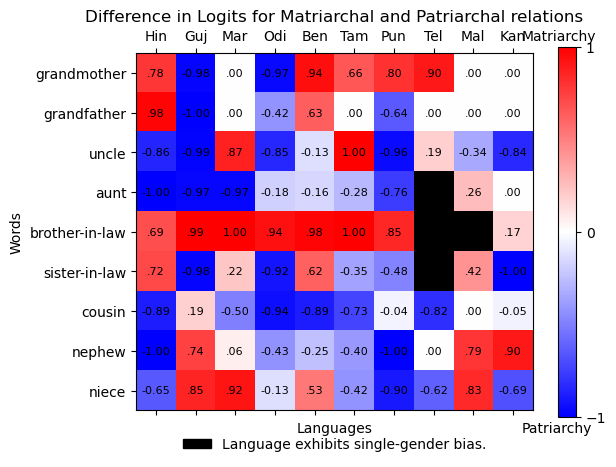

In [28]:
# show a confusion matrix plot from matplotlib of the final_res. rows are langs, columns are words and values are differences ranging from -1 to 1


fig, ax = plt.subplots()
cmap = plt.cm.bwr  # Base colormap: Blue-White-Red
cmap.set_bad(color='black')  # Map NaN values to black
# give colour custommed as max value as Pink and min value as blue and 0 as white
cax = ax.matshow(confusion_mat, cmap=cmap)
# fig.colorbar(cax)
# Create the plot
cax = ax.matshow(confusion_mat, cmap=cmap,)# norm=Normalize(vmin=-1, vmax=1))

# Annotate values in the matrix
# rows, cols = confusion_mat.shape
rows = len(confusion_mat)
cols = len(confusion_mat[0])
for i in range(rows):
    for j in range(cols):
        value = confusion_mat[i][j]
        if not np.isnan(value):  # Skip NaN values
            ax.text(j, i, f'{value:.2f}'.lstrip('0'), ha='center', va='center', fontsize=8, color = 'black')


# Add colorbar
cbar = fig.colorbar(cax)

# Customize colorbar tick labels
cbar.set_ticks([-1, 0, 1])  # Set ticks at min, mid, and max
# cbar.set_ticklabels(["Patriarchy", "Neutral", "Matriarchy"]) 
cbar.ax.text(0.5, -0.03, "Patriarchy", ha="center", va="center", fontsize=10,   transform=cbar.ax.transAxes)
cbar.ax.text(0.5, 1.03, "Matriarchy", ha="center", va="center", fontsize=10,   transform=cbar.ax.transAxes)
 
ax.set_xticks(range(len(final_res.keys()))) 
ax.set_xticklabels( list(lang_code_map[lang] for lang in final_res.keys()),  ha="center")
ax.set_yticklabels([''] + list(final_res['ory_Orya'].keys()))
plt.xlabel('Languages')
plt.ylabel('Words')
plt.title('Difference in Logits for Matriarchal and Patriarchal relations')
# save the image to a file
# Add a small black box legend below the plot
black_patch = mpatches.Patch(color='black', label='Language exhibits single-gender bias.')
plt.legend(handles=[black_patch], loc='lower center', bbox_to_anchor=(0.5, -0.15), ncol=1, fontsize=10, frameon=False)
fig.tight_layout()
fig.savefig('results/logit_prob_diff_'+str(SAMPLE_SIZE)+'num.png')
plt.show()



/tmp/ipykernel_2023387/3193793266.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + list(final_res['ory_Orya'].keys()))


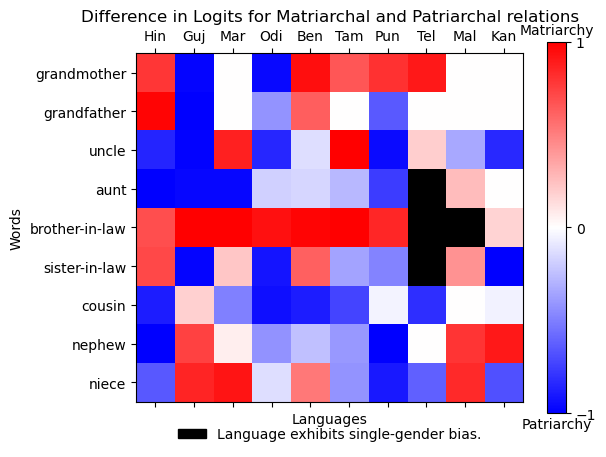

In [45]:
# show a confusion matrix plot from matplotlib of the final_res. rows are langs, columns are words and values are differences ranging from -1 to 1

fig, ax = plt.subplots()
cmap = plt.cm.bwr  # Base colormap: Blue-White-Red
cmap.set_bad(color='black')  # Map NaN values to black
# give colour custommed as max value as Pink and min value as blue and 0 as white
cax = ax.matshow(confusion_mat, cmap=cmap)
# fig.colorbar(cax)
# Create the plot
# cax = ax.matshow(confusion_mat, cmap=cmap,)# norm=Normalize(vmin=-1, vmax=1))

# Add colorbar
cbar = fig.colorbar(cax)

# Customize colorbar tick labels
cbar.set_ticks([-1, 0, 1])  # Set ticks at min, mid, and max
# cbar.set_ticklabels(["Patriarchy", "Neutral", "Matriarchy"]) 
cbar.ax.text(0.5, -0.03, "Patriarchy", ha="center", va="center", fontsize=10,   transform=cbar.ax.transAxes)
cbar.ax.text(0.5, 1.03, "Matriarchy", ha="center", va="center", fontsize=10,   transform=cbar.ax.transAxes)
 
ax.set_xticks(range(len(final_res.keys()))) 
ax.set_xticklabels( list(lang_code_map[lang] for lang in final_res.keys()),  ha="center")
ax.set_yticklabels([''] + list(final_res['ory_Orya'].keys()))
plt.xlabel('Languages')
plt.ylabel('Words')
plt.title('Difference in Logits for Matriarchal and Patriarchal relations')
# save the image to a file
# Add a small black box legend below the plot
black_patch = mpatches.Patch(color='black', label='Language exhibits single-gender bias.')
plt.legend(handles=[black_patch], loc='lower center', bbox_to_anchor=(0.5, -0.15), ncol=1, fontsize=10, frameon=False)
fig.tight_layout()
fig.savefig('results/logit_prob_diff_'+str(SAMPLE_SIZE)+'.png')
plt.show()


In [30]:
# index of ['ମାମୁଁ', 'ମଉସା'] in vocab of en_indic_tokenizer
# print(en_indic_tokenizer.convert_tokens_to_ids(['ମାମୁଁ', 'ମଉସା'])) #[3, 3] - wrong

# print(en_indic_tokenizer.vocab



In [31]:
# # import the test_sentences_eng.txt file data as sents

# # sents = ['The river is blue.', 'My uncle wearing blue coat.', 'My maternal aunt went to the river bank.', "The doctor went to bank for money."]
# sents=['My maternal aunt went to the river bank.', 'My maternal aunt loves me.', 
#        'My maternal aunt loves her grandchildren.', "My maternal aunt loves her children.", 
#        "My maternal aunt loves her family.",
#        ]   
# src_lang = "eng_Latn"

# tgt_lang = 'hin_Deva'
# # print(lang)
# translations, logits = batch_translate(sents, src_lang, tgt_lang, en_indic_model, en_indic_tokenizer, ip_en_ind)


In [32]:
# print(translations)

In [33]:
# print(logits)

Verify for Odia that logits at correct positions have been extracted

In [34]:
# for each logit in logits, convert it to prob using softmax
for lang in lang_script_list:
    if lang != 'ory_Orya':
        continue
    logits = output_logits[lang]
    softmax_logits = [softmax(logit, dim=-1) for logit in logits]
    print(softmax_logits)
    print(len(softmax_logits) ) # for each sentence translated)
    print(softmax_logits[0].shape) # for each word in the sentence; vocab size

# for each sentence, amongs all vocab logits, find the difference of [sum of matrirach words] - [sum of patriarch words]
# find the root word in english and as per lang, find the other Matriarch or Patriarch words based on relation code 

[tensor([3.5763e-07, 3.5763e-07, 5.9605e-08,  ..., 3.5763e-07, 3.5763e-07,
        3.5763e-07], dtype=torch.float16), tensor([4.1723e-07, 4.1723e-07, 1.1921e-07,  ..., 4.1723e-07, 4.1723e-07,
        4.1723e-07], dtype=torch.float16), tensor([9.5367e-07, 9.5367e-07, 6.5565e-07,  ..., 9.5367e-07, 9.5367e-07,
        9.5367e-07], dtype=torch.float16), tensor([1.0133e-06, 1.0133e-06, 4.1723e-07,  ..., 1.0133e-06, 1.0133e-06,
        1.0133e-06], dtype=torch.float16), tensor([5.3644e-07, 5.3644e-07, 1.1921e-07,  ..., 5.3644e-07, 5.3644e-07,
        5.3644e-07], dtype=torch.float16), tensor([7.1526e-07, 7.1526e-07, 2.3842e-07,  ..., 7.1526e-07, 7.1526e-07,
        7.1526e-07], dtype=torch.float16), tensor([1.0133e-06, 1.0133e-06, 2.9802e-07,  ..., 1.0133e-06, 1.0133e-06,
        1.0133e-06], dtype=torch.float16), tensor([3.5763e-07, 3.5763e-07, 1.7881e-07,  ..., 3.5763e-07, 3.5763e-07,
        3.5763e-07], dtype=torch.float16), tensor([9.5367e-07, 9.5367e-07, 2.3842e-07,  ..., 9.5367e-07, 9

In [35]:
# get the index of max prob for each logit
max_prob_index = [torch.argmax(softmax_logit, dim=-1) for softmax_logit in softmax_logits]
print(max_prob_index)

[tensor(41445), tensor(41445), tensor(9971), tensor(30261), tensor(5442), tensor(4569), tensor(60824), tensor(4300), tensor(980), tensor(41445), tensor(41445), tensor(9971), tensor(30261), tensor(5442), tensor(4569), tensor(60824), tensor(4300), tensor(980), tensor(41445), tensor(41445), tensor(9971), tensor(30261), tensor(5442), tensor(4569), tensor(60824), tensor(4300), tensor(980), tensor(41445), tensor(41445), tensor(9971)]


In [36]:
# from the softmax_logits, get the indices of top 10 max prob 
top_10_indices = [torch.topk(softmax_logit, k=10, dim=-1) for softmax_logit in softmax_logits]
print(top_10_indices)

[torch.return_types.topk(
values=tensor([0.8823, 0.0048, 0.0035, 0.0031, 0.0028, 0.0021, 0.0021, 0.0016, 0.0016,
        0.0014], dtype=torch.float16),
indices=tensor([41445,    80,    30,  8911, 51174, 29498, 33622, 48446, 30261, 30502])), torch.return_types.topk(
values=tensor([0.8306, 0.0312, 0.0203, 0.0101, 0.0087, 0.0076, 0.0056, 0.0024, 0.0017,
        0.0010], dtype=torch.float16),
indices=tensor([41445, 53208, 15588, 20077, 30502,    30,   409,  1111, 55513, 51174])), torch.return_types.topk(
values=tensor([0.5093, 0.1919, 0.0316, 0.0116, 0.0104, 0.0051, 0.0042, 0.0039, 0.0035,
        0.0035], dtype=torch.float16),
indices=tensor([ 9971, 41565, 24501,    30, 41445,  7610, 20077,  3991,  3617, 15588])), torch.return_types.topk(
values=tensor([0.6060, 0.0270, 0.0156, 0.0095, 0.0076, 0.0057, 0.0052, 0.0051, 0.0051,
        0.0049], dtype=torch.float16),
indices=tensor([30261, 41445,  9971,    30,  3617,   213, 54203,   336, 58401,  1390])), torch.return_types.topk(
values=tensor(

In [37]:
# from the top_10_indices, get the words in Hindi vocab using tokenizer.target_tokenizer
word_list = []
for i in top_10_indices:
    with en_indic_tokenizer.as_target_tokenizer():
        word_list.append(en_indic_tokenizer.batch_decode(i.indices))
print(word_list)

[['जेजे ', 'न ', "' ", 'नानी ', 'नाति ', 'दादी ', 'माआ ', 'दिदि ', 'माउ ', 'पिताम '], ['जेजे ', 'पितामह ', 'दादा ', 'बापा ', 'पिताम ', "' ", 'द ', 'बड़ ', 'बापाङ्क ', 'नाति '], ['माम ', 'काका ', 'मामा ', "' ", 'जेजे ', 'काक ', 'बापा ', 'भाइ ', 'खु ', 'दादा '], ['माउ ', 'जेजे ', 'माम ', "' ", 'खु ', 'अ ', 'माङ्क ', 'ब ', 'कुनि ', 'बो '], ['भि ', 'श् ', 'भा ', 'ज् ', 'भ ', 'श ', 'बो ', 'सा ', 'भाइ ', 'भाइर '], ['भा ', 'भि ', 'श् ', 'बो ', 'भउणी ', 'झ ', 'ज् ', 'श ', 'भ ', 'शा '], ['सम्पर्कीय़ ', 'भाइ ', 'माम ', 'भ्रातृ ', 'सम्प ', 'भउणी ', 'जणे ', 'बड़ ', 'भ्र ', 'क '], ['पुत ', 'भण ', 'भ ', 'भाइ ', "' ", 'पु ', 'भ्र ', 'भा ', 'सान ', 'सम्पर्कीय़ '], ['भ ', 'भण ', 'पुत ', 'झ ', 'भा ', 'भउणी ', 'भग ', 'भाइ ', 'बो ', 'जणे '], ['जेजे ', 'न ', 'नानी ', "' ", 'दादी ', 'नाति ', 'दिदि ', 'माआ ', 'आइ ', 'मात '], ['जेजे ', 'पितामह ', 'दादा ', 'पिताम ', 'बापा ', 'द ', "' ", 'बड़ ', 'बापाङ्क ', 'दाद '], ['माम ', 'काका ', 'मामा ', "' ", 'जेजे ', 'काक ', 'चाचा ', 'बापा ', 'दादा ', 'खु '], ['माउ ', 'ज

/home/sofia/anaconda3/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:4126: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


In [38]:
for _ in word_list:
    print(_)

['जेजे ', 'न ', "' ", 'नानी ', 'नाति ', 'दादी ', 'माआ ', 'दिदि ', 'माउ ', 'पिताम ']
['जेजे ', 'पितामह ', 'दादा ', 'बापा ', 'पिताम ', "' ", 'द ', 'बड़ ', 'बापाङ्क ', 'नाति ']
['माम ', 'काका ', 'मामा ', "' ", 'जेजे ', 'काक ', 'बापा ', 'भाइ ', 'खु ', 'दादा ']
['माउ ', 'जेजे ', 'माम ', "' ", 'खु ', 'अ ', 'माङ्क ', 'ब ', 'कुनि ', 'बो ']
['भि ', 'श् ', 'भा ', 'ज् ', 'भ ', 'श ', 'बो ', 'सा ', 'भाइ ', 'भाइर ']
['भा ', 'भि ', 'श् ', 'बो ', 'भउणी ', 'झ ', 'ज् ', 'श ', 'भ ', 'शा ']
['सम्पर्कीय़ ', 'भाइ ', 'माम ', 'भ्रातृ ', 'सम्प ', 'भउणी ', 'जणे ', 'बड़ ', 'भ्र ', 'क ']
['पुत ', 'भण ', 'भ ', 'भाइ ', "' ", 'पु ', 'भ्र ', 'भा ', 'सान ', 'सम्पर्कीय़ ']
['भ ', 'भण ', 'पुत ', 'झ ', 'भा ', 'भउणी ', 'भग ', 'भाइ ', 'बो ', 'जणे ']
['जेजे ', 'न ', 'नानी ', "' ", 'दादी ', 'नाति ', 'दिदि ', 'माआ ', 'आइ ', 'मात ']
['जेजे ', 'पितामह ', 'दादा ', 'पिताम ', 'बापा ', 'द ', "' ", 'बड़ ', 'बापाङ्क ', 'दाद ']
['माम ', 'काका ', 'मामा ', "' ", 'जेजे ', 'काक ', 'चाचा ', 'बापा ', 'दादा ', 'खु ']
['माउ ', 'जेजे ', 'माम '

# CONCLUSION

Found logits for ambiguos english words just before translating